In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import  ncx2
import pandas as pd
from numba import  njit

In [50]:
class StochasticProcess:
    def __init__(self, params, T, Nx, Nt, init_state = None):
        self.params = params
        self.T = T
        self.Nx = Nx # Number of trajectories
        self.Nt = Nt # Number of discretization steps
        self.init_state = init_state

    #Wiener Process by default
    #use @staticmethod for numba compatibility with @njit
    @staticmethod
    @njit
    def bxt(x, t, params):
        return 0

    @staticmethod
    @njit
    def sigmaxt(x, t, params):
        return 1

    @staticmethod
    @njit
    def bxt_x(x, t, params):
        return 0

    @staticmethod
    @njit
    def bxt_xx(x, t, params):
        return 0

    @staticmethod
    @njit
    def sigmaxt_x(x, t, params):
        return 0

    @staticmethod
    @njit
    def sigmaxt_xx(x, t, params):
        return 0

    @staticmethod
    @njit
    def bxt_t(x, t, params):
        return 0

    def DefaultInitState(self):
        return np.zeros(self.Nx)

    def EulerSolution(self, dwt = None):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if dwt is None:
            dwt = np.random.normal(0, 1, size = (self.Nt, self.Nx)) * np.sqrt(dt)

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + self.bxt(x_data[i - 1], t_data[i - 1], self.params) * dt +\
                        self.sigmaxt(x_data[i - 1], t_data[i - 1], self.params) * dwt[i - 1]
        return t_data, x_data

    def Milstein2Solution(self, dwt = None):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if dwt is None:
            dwt = np.random.normal(0, 1, size = (self.Nt, self.Nx)) * np.sqrt(dt)

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + (self.bxt(x_data[i - 1], t_data[i - 1], self.params) - 1/2 * self.sigmaxt(x_data[i - 1], t_data[i - 1], self.params) * self.sigmaxt_x(x_data[i - 1], t_data[i - 1], self.params)) * dt +\
                        self.sigmaxt(x_data[i - 1], t_data[i - 1], self.params) * dwt[i - 1] + 1/2 * self.sigmaxt(x_data[i - 1], t_data[i - 1], self.params) * self.sigmaxt_x(x_data[i - 1], t_data[i - 1], self.params) * dwt[i - 1]**2 +\
                        (1/2 * self.bxt(x_data[i - 1], t_data[i - 1], self.params) * self.sigmaxt_x(x_data[i - 1], t_data[i - 1], self.params) + 1/2 * self.bxt_x(x_data[i - 1], t_data[i - 1], self.params) * self.sigmaxt(x_data[i - 1], t_data[i - 1], self.params) +\
                        1/4 * self.sigmaxt(x_data[i - 1], t_data[i - 1], self.params)**2 * self.sigmaxt_xx(x_data[i - 1], t_data[i - 1], self.params)) * dt * dwt[i - 1] +\
                        (1/2 * self.bxt(x_data[i - 1], t_data[i - 1], self.params) * self.bxt_x(x_data[i - 1], t_data[i - 1], self.params) + 1/4 * self.bxt_xx(x_data[i - 1], t_data[i - 1], self.params) * self.sigmaxt(x_data[i - 1], t_data[i - 1], self.params)**2) * dt**2
        return t_data, x_data


class CIRprocess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

    # params = [theta1, theta2, theta3]
    @staticmethod
    @njit
    def bxt(x, t, params):
        return params[0] - params[1] * x

    @staticmethod
    @njit
    def sigmaxt(x, t, params):
        return params[2] * np.sqrt(np.maximum(x,0))

    @staticmethod
    @njit
    def bxt_x(x, t, params):
        return -params[1]
    

    @staticmethod
    @njit
    def sigmaxt_x(x, t, params):
        return params[2] * 1/2 * 1/np.sqrt(np.maximum(x,0))

    @staticmethod
    @njit
    def sigmaxt_xx(x, t, params):
        return -params[2] * 1/4 * 1/np.maximum(x,0)**(3/2)

    def DefaultInitState(self):
        return self.params[0] / self.params[1] * np.ones(self.Nx)

    def ExactSolution(self, dwt = None):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        theta1 = self.params[0]
        theta2 = self.params[1]
        theta3 = self.params[2]

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        if dwt is None:
            dwt = np.random.normal(0, 1, size = (self.Nt, self.Nx)) * np.sqrt(dt)

        Ito_integral_sum = np.zeros(self.Nx)
        for i in range(1, self.Nt + 1):
            Determinated_part = (x_data[0] - theta1 / theta2) * np.exp(-theta2 * t_data[i]) + theta1/theta2
            #avoiding exp overflow
            Ito_integral_sum = (Ito_integral_sum + theta3 * np.sqrt(np.maximum(x_data[i - 1], 0)) * dwt[i - 1]) * np.exp(-theta2 * dt)
            x_data[i] = Determinated_part + Ito_integral_sum
        return t_data, x_data

    def StationaryState(self):
        theta1 = self.params[0]
        theta2 = self.params[1]
        theta3 = self.params[2]

        k = theta2
        theta = theta1 / theta2
        sigma = theta3

        c = 2 * k / (sigma**2)
        u = 0
        q = 2 * k * theta / sigma**2 - 1

        return ncx2.rvs(2 * q + 2, 2 * u, size = self.Nx) / (2 * c)

    def ProcessDistribution(self, x, t, x0, t0):
        theta1 = self.params[0]
        theta2 = self.params[1]
        theta3 = self.params[2]

        k = theta2
        theta = theta1 / theta2
        sigma = theta3

        c = 2 * k / (sigma**2 * (1 - np.exp(-k * (t - t0))))
        u = c * x0 * np.exp(-k * (t - t0))
        #v = c * x
        q = 2 * k * theta / sigma**2 - 1
        return ncx2.pdf(2 * c * x, 2 * q + 2, 2 * u) * (2 * c) #2c is normalazing constant

    def StationaryDistribution(self, x):
        theta1 = self.params[0]
        theta2 = self.params[1]
        theta3 = self.params[2]

        k = theta2
        theta = theta1 / theta2
        sigma = theta3

        c = 2 * k / (sigma**2)
        u = 0
        q = 2 * k * theta / sigma**2 - 1
        return ncx2.pdf(2 * c * x, 2 * q + 2, 2 * u) * (2 * c)

Task 1. Simulate a Cox-Ingersoll-Ross (CIR) model
$$
dX_t = (\theta_1 - \theta_2 X_t)dt + \theta_3 \sqrt{X_t}dW_t
$$
with $\theta = (6, 2, 1)$, and choose the bandwidth according to Scott’s rule and implement the non-parametric kernel estimation for stationary density of the CIR model.

Plot in a graph the true stationary density against the estimated one for two approaches
*  compute on the single trajectory  (set $T$ very large, time discretization step set as $T/N_t = \Delta t$);
*  compute on the Nx trajectories.




In [3]:
def StationaryDistributionKernelEstimator(x, x_data, delta = None):
    n = len(x_data)
    m = 1

    hn = 1

    if delta is None:
        hn = np.std(x_data) * n**(-1 / (m + 4))
    else:
        hn = delta

    pi = np.zeros(len(x))

    for j in range(0, len(x)):
        K = 1/np.sqrt(2 * np.pi) * np.exp(-1/2 * (x[j] - x_data)**2 / hn**2)

        pi[j] = 1 / (n * hn) * np.sum(K)

    return pi

In [4]:
# approach 1

Nx = 1
Nt = 100000
T = 1000

params_CIR = [6, 2, 1]

CIRp = CIRprocess(params_CIR, T, Nx, Nt)
CIRp.init_state = CIRp.StationaryState()
t_data, x_data_CIR = CIRp.ExactSolution()

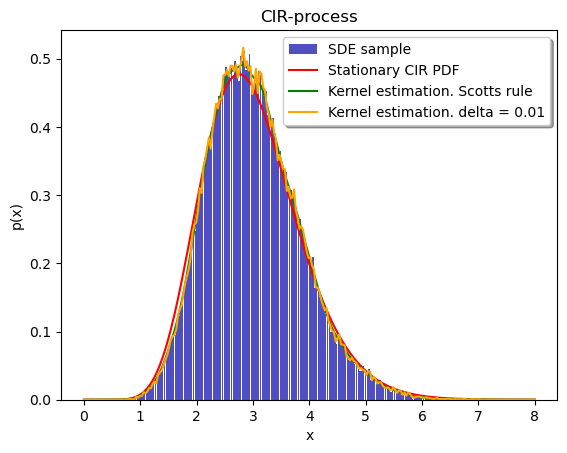

In [5]:
n = np.random.randint(0, Nt)
fig, ax = plt.subplots()
x_data = np.linspace(0, 8, 250)

i = np.random.randint(0, Nt)

n, bins, patches = ax.hist(x_data_CIR.flatten(), bins=x_data, density=True, color='#0504aa', alpha=0.7, rwidth=0.85, label = 'SDE sample')
ax.set_xlabel('x')
ax.set_ylabel('p(x)')
ax.set_title(f'CIR-process', loc = 'center')

ax.plot(x_data, CIRp.StationaryDistribution(x_data), label = 'Stationary CIR PDF', color = 'red')
ax.plot(x_data, StationaryDistributionKernelEstimator(x_data, x_data_CIR.flatten()), label = f'Kernel estimation. Scotts rule', color = 'green')

d = 0.01
ax.plot(x_data, StationaryDistributionKernelEstimator(x_data, x_data_CIR.flatten(), delta = d),
        label = f'Kernel estimation. delta = {d}', color = 'orange')

ax.legend(loc = 'upper right', fancybox = True, shadow = True)
plt.show()

In [6]:
# approach 2

Nx = 15000
Nt = 300

T = 1

params_CIR = [6, 2, 1]

CIRp = CIRprocess(params_CIR, T, Nx, Nt)
CIRp.init_state = CIRp.StationaryState()
t_data, x_data_CIR = CIRp.ExactSolution()

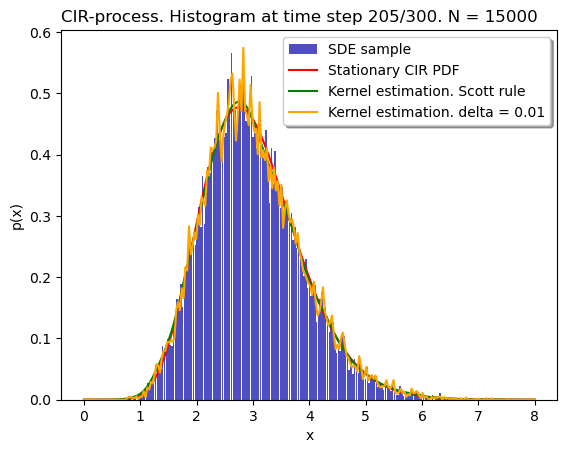

In [7]:
n = np.random.randint(0, Nt)
fig, ax = plt.subplots()
x_data = np.linspace(0, 8, 250)

i = np.random.randint(0, Nt)

n, bins, patches = ax.hist(x_data_CIR[i], bins=x_data, density=True, color='#0504aa', alpha=0.7, rwidth=0.85, label = 'SDE sample')
ax.set_xlabel('x')
ax.set_ylabel('p(x)')
ax.set_title(f'CIR-process. Histogram at time step {i}/{Nt}. N = {Nx}', loc = 'left')

ax.plot(x_data, CIRp.StationaryDistribution(x_data), label = 'Stationary CIR PDF', color = 'red')
ax.plot(x_data, StationaryDistributionKernelEstimator(x_data, x_data_CIR[i]), label = f'Kernel estimation. Scott rule', color = 'green')

d = 0.01
ax.plot(x_data, StationaryDistributionKernelEstimator(x_data, x_data_CIR[i], delta = d),
        label = f'Kernel estimation. delta = {d}', color = 'orange')

ax.legend(loc = 'upper right', fancybox = True, shadow = True)
plt.show()

Task. Estimate the quality of the obtained approximations with statistical criteria and provide conclusions.

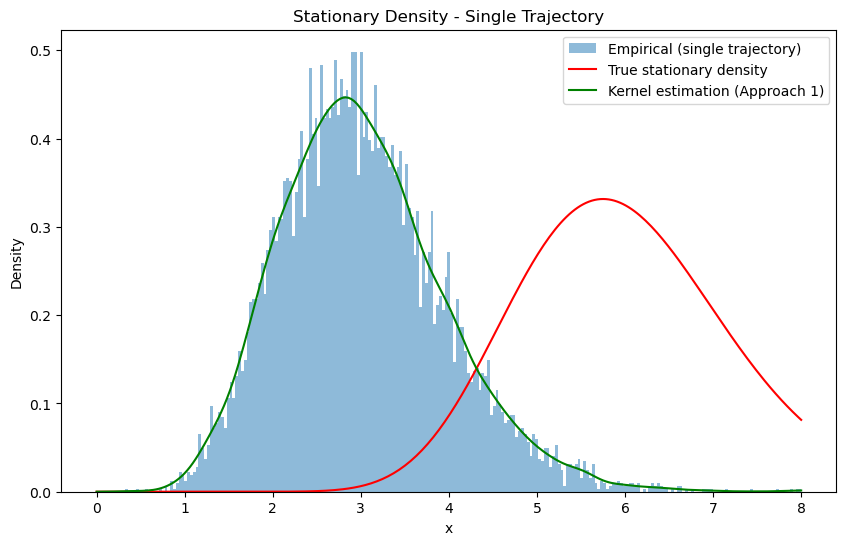

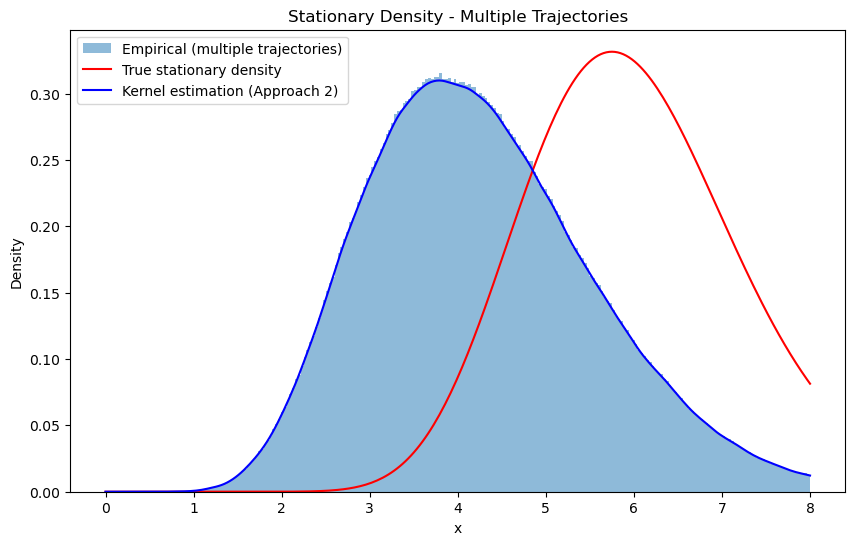

Approach 1: Критерий Колмогорова-Смирнова = 0.268, P-value = 0.0
 Approach 2: Критерий Колмогорова-Смирнова = 0.212, P-value = 0.0


In [14]:
from scipy.stats import ks_2samp

params_CIR = [6, 2, 1]

# Approach 1: Single trajectory
Nx1, Nt1, T1 = 1, 10000, 1000
CIRp1 = CIRprocess(params_CIR, T1, Nx1, Nt1)
CIRp1.init_state = CIRp1.StationaryState()
_, x_data_CIR1 = CIRp1.ExactSolution()

# Approach 2: Multiple trajectories
Nx2, Nt2, T2 = 15000, 300, 1
CIRp2 = CIRprocess(params_CIR, T2, Nx2, Nt2)
CIRp2.init_state = CIRp2.StationaryState()
_, x_data_CIR2 = CIRp2.ExactSolution()

x_grid = np.linspace(0, 8, 250)

true_stationary_density = CIRp1.StationaryDistribution(x_grid)

kernel_density_1 = StationaryDistributionKernelEstimator(x_grid, x_data_CIR1.flatten())
kernel_density_2 = StationaryDistributionKernelEstimator(x_grid, x_data_CIR2.flatten())

ks_stat_1, ks_pval_1 = ks_2samp(kernel_density_1, true_stationary_density)
ks_stat_2, ks_pval_2 = ks_2samp(kernel_density_2, true_stationary_density)


plt.figure(figsize=(10, 6))
plt.hist(x_data_CIR1.flatten(), bins=x_grid, density=True, alpha=0.5, label="Empirical (single trajectory)")
plt.plot(x_grid, true_stationary_density, label="True stationary density", color="red")
plt.plot(x_grid, kernel_density_1, label="Kernel estimation (Approach 1)", color="green")
plt.title("Stationary Density - Single Trajectory")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.show()


plt.figure(figsize=(10, 6))
plt.hist(x_data_CIR2.flatten(), bins=x_grid, density=True, alpha=0.5, label="Empirical (multiple trajectories)")
plt.plot(x_grid, true_stationary_density, label="True stationary density", color="red")
plt.plot(x_grid, kernel_density_2, label="Kernel estimation (Approach 2)", color="blue")
plt.title("Stationary Density - Multiple Trajectories")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.show()


print(f'Approach 1: Критерий Колмогорова-Смирнова = {round(ks_stat_1, 4)}, P-value = {round(ks_pval_1, 4)}\n',
      f'Approach 2: Критерий Колмогорова-Смирнова = {round(ks_stat_2, 4)}, P-value = {round(ks_pval_2, 4)}'
      )


### Вывод

Критерий Колмогорова-Смирнова показывает низкое знаечние 𝑝-value для обоих подходов, что указывает на статистическую значимость отличий между аппроксимированной и истинной плотностью.

Task. Study the effect of the bandwidth $h_n$ and the mesh $∆_n$ on the kernel estimator and plot a 3D graph.

In [24]:
from tqdm import tqdm

def KernelDensityEstimator(x, x_data, bandwidth=None):
    n = len(x_data)
    if bandwidth is None:
        bandwidth = np.std(x_data) * n ** (-1 / 5)  # Правило Скотта
    kernel_values = (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x[:, None] - x_data[None, :]) / bandwidth) ** 2)
    return np.sum(kernel_values, axis=1) / (n * bandwidth)

class CIRModel:
    def __init__(self, params, T, num_paths, num_steps, X0=1):
        self.params = params
        self.T = T
        self.num_paths = num_paths
        self.num_steps = num_steps
        self.X0 = X0
        self.dt = T / num_steps

    def simulate(self):
        theta1, theta2, theta3 = self.params
        dt = self.dt
        X = np.zeros((self.num_paths, self.num_steps))
        X[:, 0] = self.X0

        for t in range(1, self.num_steps):
            dW = np.sqrt(dt) * np.random.randn(self.num_paths)
            X[:, t] = X[:, t-1] + (theta1 - theta2 * X[:, t-1]) * dt + theta3 * np.sqrt(np.maximum(X[:, t-1], 0)) * dW
            X[:, t] = np.maximum(X[:, t], 0)  # Условие положительности

        return X

    def stationary_density(self, x):
        # Теоретическая стационарная плотность для CIR
        theta1, theta2, theta3 = self.params
        kappa = 2 * theta1 / theta3**2
        theta = 2 * theta2 / theta3**2
        normalization = (theta**kappa / np.math.gamma(kappa)) * (x**(kappa - 1)) * np.exp(-theta * x)
        return normalization

Processing Mesh Sizes: 100%|██████████| 15/15 [00:07<00:00,  2.11it/s]


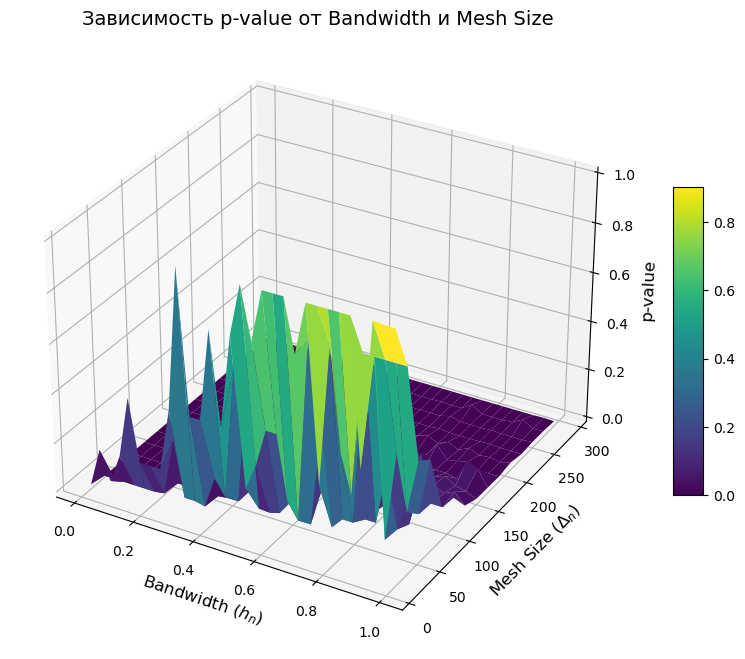

In [25]:
params = [6, 2, 1]
T = 1
num_paths = 300
num_steps = 3000

# Генерация данных
model = CIRModel(params, T, num_paths, num_steps)
data = model.simulate()

# Задаем диапазоны для анализа
bandwidth_values = np.linspace(0.01, 1, 30)
mesh_sizes = np.arange(10, 300, 20)
p_values_matrix = []

for mesh in tqdm(mesh_sizes, desc="Processing Mesh Sizes"):
    row = []
    x_range = np.linspace(0, 8, mesh)
    for bandwidth in bandwidth_values:
        traj_idx = np.random.choice(num_paths, 1)
        x_data = data[traj_idx].flatten()

        kernel_density = KernelDensityEstimator(x_range, x_data, bandwidth=bandwidth)
        true_density = model.stationary_density(x_range)

        _, p_value = ks_2samp(true_density, kernel_density)
        row.append(p_value)

    p_values_matrix.append(row)

p_values_matrix = np.array(p_values_matrix)

X, Y = np.meshgrid(bandwidth_values, mesh_sizes)
Z = p_values_matrix

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection="3d")
surf = ax.plot_surface(X, Y, Z, cmap="viridis", edgecolor="none")

ax.set_title("Зависимость p-value от Bandwidth и Mesh Size", fontsize=14)
ax.set_xlabel("Bandwidth ($h_n$)", fontsize=12)
ax.set_ylabel("Mesh Size ($\Delta_n$)", fontsize=12)
ax.set_zlabel("p-value", fontsize=12)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

plt.show()


Task. Repeat previos tasks on the Chan-Karolyi-Longstaff-Sanders (CKLS) model
\begin{equation*}%\label{eq09}
 dX_{t} = (\theta_{1}+\theta_{2} X_{t}) dt + \theta_{3} X_{t}^{\theta_{4}} dW_{t},\qquad X_{0}=2
\end{equation*}
with $\theta_{1}=1$, $\theta_{2}=2$, $\theta_{3}=0.5$, $\theta_{4}=0.3$.

In [30]:
from scipy.stats import gaussian_kde

class CKLSprocess:
    def __init__(self, params, T, Nx, Nt, init_state=None):
        self.params = np.array(params, dtype=np.float64)
        self.T = T
        self.Nx = Nx
        self.Nt = Nt
        self.dt = T / Nt
        self.init_state = init_state if init_state is not None else self.DefaultInitState()
        self.state = np.zeros((Nx, Nt), dtype=np.float64)

    @staticmethod
    @njit
    def bxt(x, t, params):
        return params[0] + params[1] * x

    @staticmethod
    @njit
    def sigmaxt(x, t, params):
        return params[2] * (x ** params[3])

    def DefaultInitState(self):
        return -self.params[0] / self.params[1] * np.ones(self.Nx, dtype=np.float64)

    def EulerSolution(self):
        np.random.seed(42)
        self.state[:, 0] = self.init_state
        for t in range(1, self.Nt):
            dW = np.sqrt(self.dt) * np.random.randn(self.Nx)
            self.state[:, t] = (
                self.state[:, t - 1]
                + self.bxt(self.state[:, t - 1], t * self.dt, self.params) * self.dt
                + self.sigmaxt(self.state[:, t - 1], t * self.dt, self.params) * dW
            )
            self.state[:, t] = np.maximum(self.state[:, t], 0)  # Условие положительности
        return np.linspace(0, self.T, self.Nt), self.state


In [35]:
def KernelDensityEstimator(x, sample, bandwidth=None):
    kde = gaussian_kde(sample, bw_method=bandwidth)
    return kde(x)

Nx = 1000
Nt = 300  
T = 1
params_CKLS = [1.0, 2.0, 0.5, 0.3]

CKLS = CKLSprocess(params_CKLS, T, Nx, Nt)
CKLS.init_state = 2 * np.ones(Nx, dtype=np.float64)
t_data, x_data_CKLS = CKLS.EulerSolution()


np.random.seed(41)
time_step = np.random.randint(0, Nt)  
x_data = np.linspace(0, 8, 250)

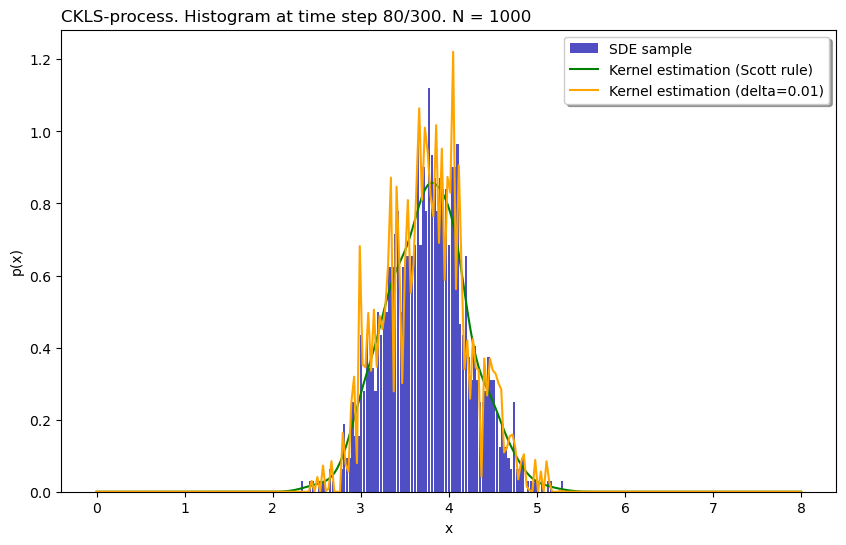

In [36]:
# Построение гистограммы
fig, ax = plt.subplots(figsize=(10, 6))
n, bins, patches = ax.hist(
    x_data_CKLS[:, time_step],
    bins=x_data,
    density=True,
    color="#0504aa",
    alpha=0.7,
    rwidth=0.85,
    label="SDE sample",
)


ax.plot(
    x_data,
    KernelDensityEstimator(x_data, x_data_CKLS[:, time_step]),
    label="Kernel estimation (Scott rule)",
    color="green",
)

delta = 0.01
ax.plot(
    x_data,
    KernelDensityEstimator(x_data, x_data_CKLS[:, time_step], bandwidth=delta),
    label=f"Kernel estimation (delta={delta})",
    color="orange",
)

ax.set_xlabel("x")
ax.set_ylabel("p(x)")
ax.set_title(f"CKLS-process. Histogram at time step {time_step}/{Nt}. N = {Nx}", loc="left")
ax.legend(loc="upper right", fancybox=True, shadow=True)

plt.show()

KS Statistic: 0.34, p-value: 2.199656687234277e-13


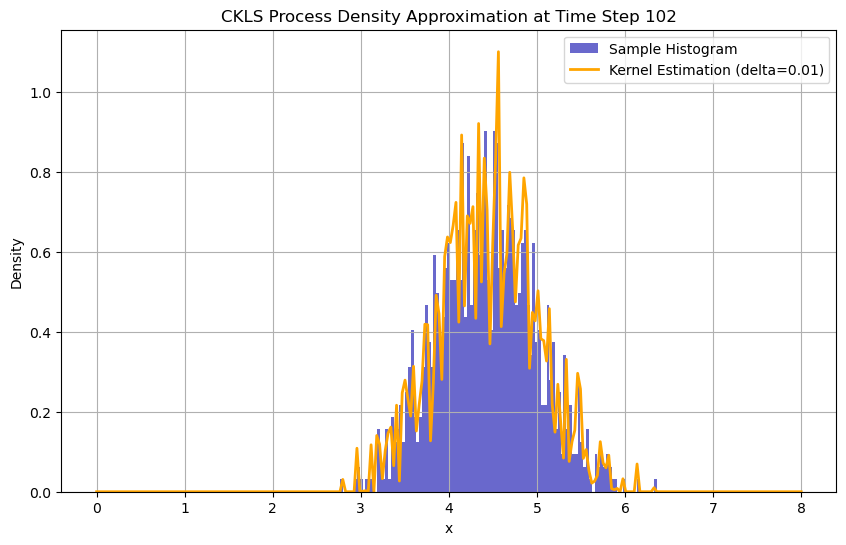

In [37]:
Nx = 1000  
Nt = 300  
T = 1 
params_CKLS = [1.0, 2.0, 0.5, 0.3]

CKLS = CKLSprocess(params_CKLS, T, Nx, Nt)
CKLS.init_state = 2 * np.ones(Nx, dtype=np.float64) 
t_data, x_data_CKLS = CKLS.EulerSolution()

np.random.seed(42)
time_step = np.random.randint(0, Nt)
x_data = np.linspace(0, 8, 250)


delta = 0.01
kernel_estimation = KernelDensityEstimator(x_data, x_data_CKLS[:, time_step], bandwidth=delta)
histogram_density, _ = np.histogram(x_data_CKLS[:, time_step], bins=x_data, density=True)
histogram_density = histogram_density / histogram_density.sum()

stat, p_value = ks_2samp(kernel_estimation, histogram_density)
print(f"KS Statistic: {stat}, p-value: {p_value}")

# Построение графика
plt.figure(figsize=(10, 6))
plt.hist(
    x_data_CKLS[:, time_step],
    bins=x_data,
    density=True,
    alpha=0.6,
    label="Sample Histogram",
    color="#0504aa",
)
plt.plot(
    x_data,
    kernel_estimation,
    label=f"Kernel Estimation (delta={delta})",
    color="orange",
    lw=2,
)
plt.title(f"CKLS Process Density Approximation at Time Step {time_step}")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.grid()
plt.show()


In [41]:
# переопределим функцию чтобы избавиться от nan и inf
def KernelDensityEstimator(x, sample, bandwidth=None):
    sample = sample[np.isfinite(sample)]
    if sample.size == 0:
        raise ValueError("Sample is empty after removing NaN and inf values.")
    
    kde = gaussian_kde(sample, bw_method=bandwidth)
    return kde(x)

meshes = list(range(10, 300, 10))
hns = np.linspace(0.01, 1.0, 50)
p_values = []

for mesh in tqdm(meshes):
    row = []
    for hn in hns:
        CKLS = CKLSprocess(params_CKLS, T, Nx, mesh)
        t_data, x_data_CKLS = CKLS.EulerSolution()
        time_step = np.random.randint(0, mesh)
        
        sample = x_data_CKLS[:, time_step]
        sample = sample[np.isfinite(sample)]
        
        if sample.size == 0:
            row.append(0)
            continue
        
        kernel_estimation = KernelDensityEstimator(x_data, sample, bandwidth=hn)
        histogram_density, _ = np.histogram(sample, bins=x_data, density=True)
        histogram_density = histogram_density / histogram_density.sum()

        _, p_value = ks_2samp(kernel_estimation, histogram_density)
        row.append(p_value)
    p_values.append(row)

p_values = np.array(p_values)


  0%|          | 0/29 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:21<00:00,  1.33it/s]


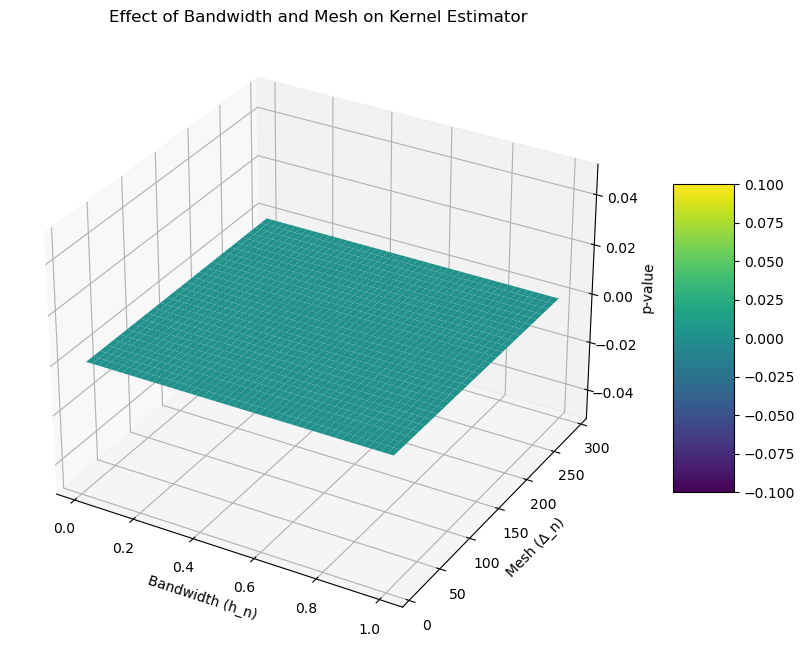

In [42]:
from mpl_toolkits.mplot3d import Axes3D

X, Y = np.meshgrid(hns, meshes)
Z = p_values

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection="3d")

# Поверхность p-value
surf = ax.plot_surface(X, Y, Z, cmap="viridis")
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

# Подписи
ax.set_xlabel("Bandwidth (h_n)")
ax.set_ylabel("Mesh (∆_n)")
ax.set_zlabel("p-value")
ax.set_title("Effect of Bandwidth and Mesh on Kernel Estimator")

plt.show()

Task 2. Implement a non-parametric drift estimator

$$
\hat{b}_n(x) = \frac{\sum_{i=0}^{n-1} K\left(\frac{x-X_i}{h_n}\right)(X_{i+1}-X_i)} {\Delta_n \sum_{i=0}^{n-1} K\left(\frac{x-X_i}{h_n}\right)}
$$

and diffusion estimator
$$
\hat{\sigma}^2_n(x) = \frac{\sum_{i=0}^{n-1} K\left(\frac{x-X_i}{h_n}\right)(X_{i+1}-X_i)^2} {\Delta_n \sum_{i=0}^{n-1} K\left(\frac{x-X_i}{h_n}\right)}.$$


for the CIR model (Task 1) and plot two graphs.
Use the Gaussian kernel $K(u) = \frac{1}{\sqrt{2\pi}} \exp \left(-\frac{1}{2}u^2\right)$.


In [59]:
from typing import Literal

def NormalKernel(z):
    return 1/np.sqrt(2 * np.pi) * np.exp(-1/2 * z**2)

def UniformKernel(z):
    return 1/2 * np.ones_like(z)

def ParabolicKernel(z):
    return 3/4 * (1 - z**2)

def Gaussian_high_order(z):
    pass

def DiffusionKernelEstimator(x, x_data, delta = None, 
                             method: Literal['normal', 'uniform', 'parabolic', 'gaussian_high_order'] = 'normal'):
    n = len(x_data)
    m = 1

    hn = 1

    hn = np.std(x_data) * n**(-1 / (m + 4))

    s2 = np.zeros(len(x))

    for j in range(0, len(x)):
        K1 = 0
        K2 = 0
        z = (x[j] - x_data)**2 / hn**2
        if method == 'normal':
            K = NormalKernel(z)
        elif method == 'uniform':
            K = UniformKernel(z)
        elif method == 'parabolic':
            K = ParabolicKernel(z)
        elif method == 'gaussian_high_order':
            K = Gaussian_high_order(z)
        else:
            raise ValueError(f"method = {method} not implemented")

        K1 = np.sum(K[0:n-1] * (x_data[1:] - x_data[0:n-1])**2)
        K2 = np.sum(K)
        if K2 == 0:
            s2[j] = 0
        else:
            s2[j] = K1 / K2

    if delta is None:
        delta = 1

    return s2 / delta

def DriftKernelEstimator(x, x_data, delta = None, 
                         method: Literal['normal', 'uniform', 'parabolic', 'gaussian_high_order'] = 'normal'):
    n = len(x_data)
    m = 1

    hn = 1

    hn = np.std(x_data) * n**(-1 / (m + 4))

    s2 = np.zeros(len(x))

    for j in range(0, len(x)):
        K1 = 0
        K2 = 0
        z = (x[j] - x_data)**2 / hn**2
        if method == 'normal':
            K = NormalKernel(z)
        elif method == 'uniform':
            K = UniformKernel(z)
        elif method == 'parabolic':
            K = ParabolicKernel(z)
        elif method == 'gaussian_high_order':
            K = Gaussian_high_order(z)
        else:
            raise ValueError(f"method = {method} not implemented")

        K1 = np.sum(K[0:n-1] * (x_data[1:] - x_data[0:n-1]))
        K2 = np.sum(K)
        if K2 == 0:
            s2[j] = 0
        else:
            s2[j] = K1 / K2

    if delta is None:
        delta = 1

    return s2 / delta

In [67]:
Nx = 1
Nt = 100000

T = 1000

x_data = np.linspace(0, 6, 200)

params_CIR = [6, 2, 1]

CIRp = CIRprocess(params_CIR, T, Nx, Nt)
t_data, x_data_CIR = CIRp.ExactSolution()

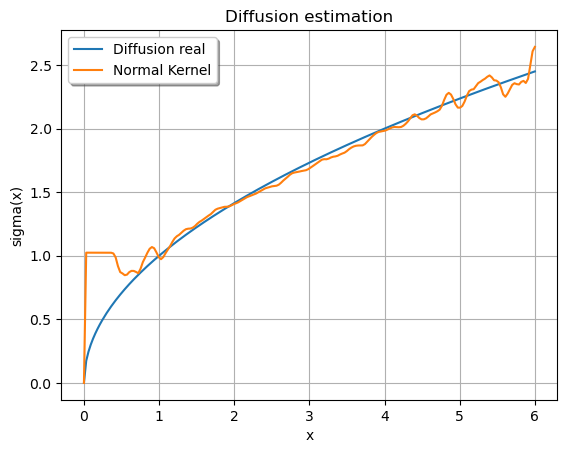

In [69]:
sigma_data = CIRp.sigmaxt(x_data, 0, CIRp.params)

plt.plot(x_data, sigma_data, label = 'Diffusion real')


diffke = DiffusionKernelEstimator(x_data, x_data_CIR.flatten(), T/Nt, 'normal')
plt.plot(x_data, np.sqrt(diffke), label = 'Normal Kernel')

plt.title("Diffusion estimation")
plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("x")
plt.ylabel("sigma(x)")
plt.grid(True)
plt.show()

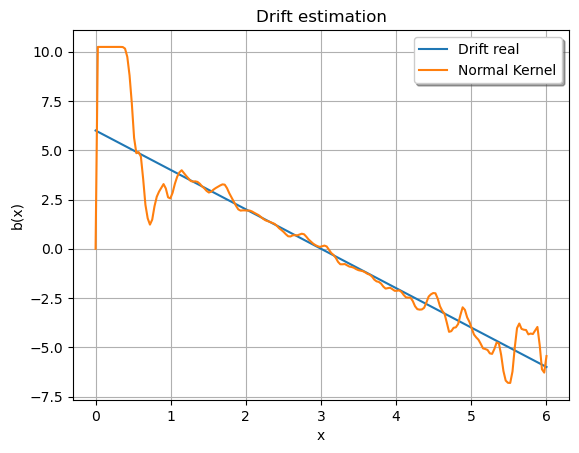

In [70]:
b_data = CIRp.bxt(x_data, 0, CIRp.params)

plt.plot(x_data, b_data, label = 'Drift real')


driftke = DriftKernelEstimator(x_data, x_data_CIR.flatten(), T/Nt, 'normal')
plt.plot(x_data, driftke, label = 'Normal Kernel')

plt.title("Drift estimation")
plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("x")
plt.ylabel("b(x)")
plt.grid(True)
plt.show()

Task. Implement a non-parametric drift
and diffusion estimators with the higher order Gaussian kernel $K(u)=\frac{3}{\sqrt{8 \pi}}(1-u^2/3)\exp({-u^2/2})$ ([p.24](https://www.nber.org/system/files/working_papers/w5345/w5345.pdf))  and add curves on graphs
for the CIR model.

Improve estimates on the left and the right subintervals $[0,1]$ and $[5,6]$ respectly.


c:\Anaconda\Lib\site-packages\numba\core\ir_utils.py:2149: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'params' of function 'CIRprocess.bxt'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "..\..\..\..\..\AppData\Local\Temp\ipykernel_17160\428143161.py", line 94:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
c:\Anaconda\Lib\site-packages\numba\core\ir_utils.py:2149: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'params' of function 'CIRprocess.sigmaxt'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "..\..\..\..\..\AppData\Local\Temp\ipykernel_17160

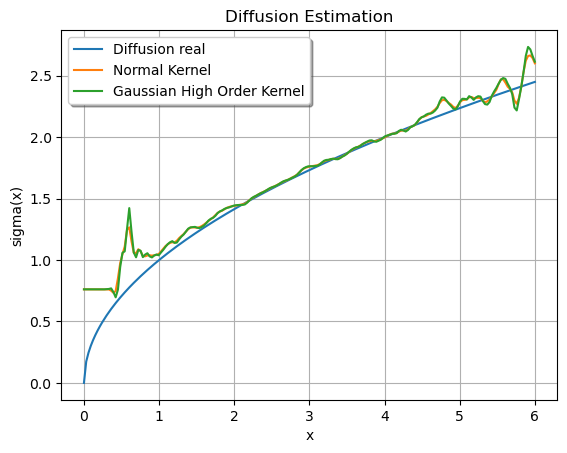

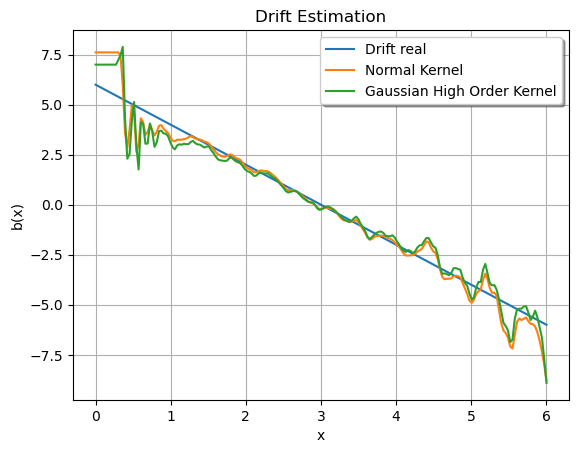

In [73]:
def GaussianHighOrderKernel(u):
    return 3 / np.sqrt(8 * np.pi) * (1 - u**2 / 3) * np.exp(-u**2 / 2)

Nx = 1
Nt = 100000
T = 1000

x_data = np.linspace(0, 6, 200)

params_CIR = [6, 2, 1]

CIRp = CIRprocess(params_CIR, T, Nx, Nt)
t_data, x_data_CIR = CIRp.EulerSolution()

sigma_data = CIRp.sigmaxt(x_data, 0, CIRp.params)

plt.plot(x_data, sigma_data, label="Diffusion real")

diffke_normal = DiffusionKernelEstimator(x_data, x_data_CIR.flatten(), T / Nt, "normal")
plt.plot(x_data, np.sqrt(diffke_normal), label="Normal Kernel")

diffke_gaussian = DiffusionKernelEstimator(x_data, x_data_CIR.flatten(), T / Nt, "gaussian_high_order")
plt.plot(x_data, np.sqrt(diffke_gaussian), label="Gaussian High Order Kernel")

plt.title("Diffusion Estimation")
plt.legend(loc="best", fancybox=True, shadow=True)
plt.xlabel("x")
plt.ylabel("sigma(x)")
plt.grid(True)
plt.show()

b_data = CIRp.bxt(x_data, 0, CIRp.params)

plt.plot(x_data, b_data, label="Drift real")

driftke_normal = DriftKernelEstimator(x_data, x_data_CIR.flatten(), T / Nt, "normal")
plt.plot(x_data, driftke_normal, label="Normal Kernel")

c = 0.45
hn = c * Nt ** (-1 / 9) / np.log(Nt)

driftke_gaussian = DriftKernelEstimator(x_data, x_data_CIR.flatten(), hn, "gaussian_high_order")
plt.plot(x_data, driftke_gaussian, label="Gaussian High Order Kernel")

plt.title("Drift Estimation")
plt.legend(loc="best", fancybox=True, shadow=True)
plt.xlabel("x")
plt.ylabel("b(x)")
plt.grid(True)
plt.show()


Ядро Гаусса высокого порядка дает более гладкую оценку, особенно на краях интервала, что улучшает приближение реального процесса. 

Оценки ядром высокого порядка демонстрируют преимущество на подинтервалах  [0,1] и [5,6], обеспечивая более точное представление реального дрейфа.